# Proteins Dataset

In [12]:
!python -c "import torch; print(torch.__version__)"

2.5.1+cu121


In [13]:
%%capture

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Import data from TUDataset

| **Property**       | **Value**         |
|---------------------|-------------------|
| Number of graphs   | 1113             |
| Number of classes  | 2                |
| Average nodes      | 39.06            |
| Average edges      | 72.82            |
| Node labels        | Yes (+)          |
| Edge labels        | No (-)          |

In [16]:
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root="data/TUDataset", name="PROTEINS")

In [ ]:
import torch
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

torch.manual_seed(42)

dataset_size = len(dataset)
train_size = dataset_size // 2
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataset = list(train_dataset)
test_dataset = list(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Number of graphs in the dataset: {len(dataset)}")
print(f"Number of features per node: {dataset.num_node_features}")
print(f"Number of classes: {dataset.num_classes}")

Simple training and testing of the model

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, depth):
        super(GCN, self).__init__()

        self.depth = depth
        # Dynamically create the GCNConv layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(input_dim, hidden_dim))
        for _ in range(1, depth):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))

        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Pass through each GCNConv layer
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)

        # Apply global mean pooling
        x = global_mean_pool(x, batch)

        # Final fully connected layer
        # x = self.fc(x)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_node_features, hidden_dim=32, output_dim=dataset.num_classes, depth=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

losses = []
train_accs = []
test_accs = []

for epoch in range(1, 201):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if epoch % 20 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    losses.append(loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

Plotting the iterations

In [ ]:
import matplotlib.pyplot as plt

# # Plot Losses
# plt.subplot(3, 1, 1)
# plt.plot(range(1, 501), losses, label='Loss', color='red')
# plt.title('Loss over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# Plot Training Accuracies
plt.subplot(2, 1, 1)
plt.plot(range(1, 201), train_accs, label=f'Training Accuracy {train_accs[-1]:3f}', color='green')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Test Accuracies
plt.subplot(2, 1, 2)
plt.plot(range(1, 201), test_accs, label=f'Test Accuracy {test_accs[-1]:3f}', color='blue')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Results

Below we display outputs of the runs of three experiments.

## Unmodified graph

| **Epoch** | **Loss** | **Train Accuracy** | **Test Accuracy** |
|-----------|----------|--------------------|-------------------|
| 20        | 0.6815   | 0.5737             | 0.5404            |
| 40        | 0.6958   | 0.6097             | 0.6535            |
| 60        | 0.6672   | 0.6367             | 0.6679            |
| 80        | 0.6754   | 0.6493             | 0.6732            |
| 100       | 0.6675   | 0.6133             | 0.6607            |
| 120       | 0.6578   | 0.6529             | 0.6679            |
| 140       | 0.6501   | 0.6097             | 0.6517            |
| 160       | 0.6568   | 0.6547             | 0.6768            |
| 180       | 0.6401   | 0.6942             | 0.7235            |
| 200       | 0.6367   | 0.6871             | 0.7199            |


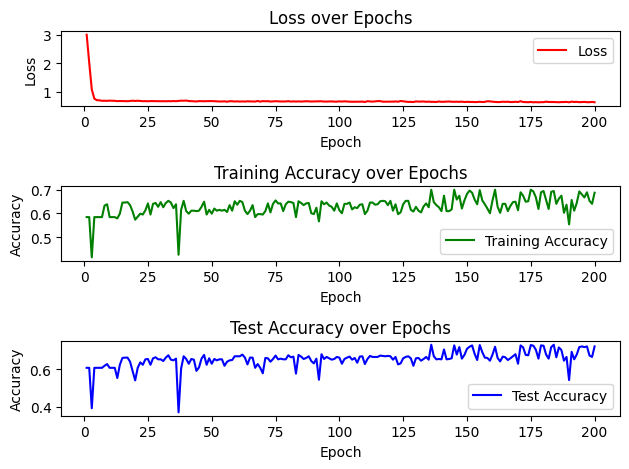

## Adding edges

| **Epoch** | **Loss** | **Train Accuracy** | **Test Accuracy** |
|-----------|----------|--------------------|-------------------|
| 20        | 0.6845   | 0.5701             | 0.5368            |
| 40        | 0.7001   | 0.6007             | 0.6230            |
| 60        | 0.6741   | 0.6619             | 0.6625            |
| 80        | 0.6780   | 0.6421             | 0.6643            |
| 100       | 0.6699   | 0.6079             | 0.6499            |
| 120       | 0.6611   | 0.6583             | 0.6679            |
| 140       | 0.6545   | 0.6097             | 0.6553            |
| 160       | 0.6614   | 0.6439             | 0.6553            |
| 180       | 0.6433   | 0.6565             | 0.6822            |
| 200       | 0.6369   | 0.6888             | 0.7253            |


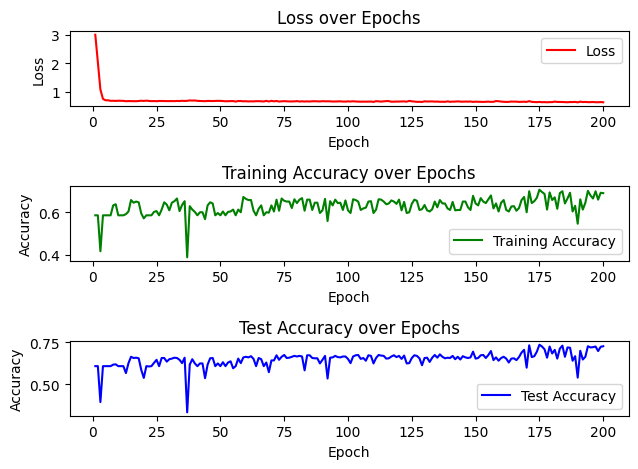

## Louvain virtual nodes

| **Epoch** | **Loss** | **Train Accuracy** | **Test Accuracy** |
|-----------|----------|--------------------|-------------------|
| 20        | 0.6829   | 0.5899             | 0.5673            |
| 40        | 0.6979   | 0.5971             | 0.6230            |
| 60        | 0.6746   | 0.6547             | 0.6607            |
| 80        | 0.6832   | 0.6529             | 0.6625            |
| 100       | 0.6753   | 0.5863             | 0.6050            |
| 120       | 0.6651   | 0.6187             | 0.6553            |
| 140       | 0.6583   | 0.5809             | 0.6086            |
| 160       | 0.6629   | 0.6151             | 0.6176            |
| 180       | 0.6505   | 0.6511             | 0.6822            |
| 200       | 0.6468   | 0.6529             | 0.6697            |

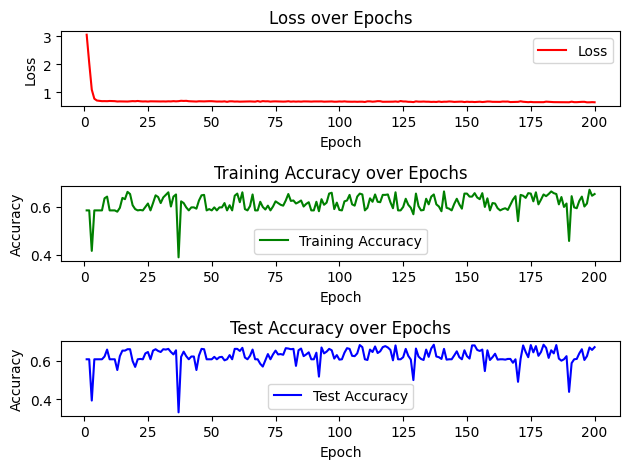

# Edges

Below you can find the code for implementing the add edges algorithm.
It does a greedy search: everytime it wants to add an edge, it tries to find what is the minimal markov chain probability between any two nodes. When it finds this pair, it connects them with an edge and continues. For computational reasons, instead of finding distances from each of the nodes, we only consider minimum between random subset of nodes (in this case size 10).

In [17]:
def calculate_markov_chain_distance_to_everything(data, target, k):
    """
    Given a specified node, it calculates a probability vector for random walk with length k
    """
    edge_index = data.edge_index.cpu().numpy()
    features = data.x.cpu().numpy()

    graph = nx.Graph()

    # Add nodes
    for i, feat in enumerate(features):
        graph.add_node(i, label=f"{i}: ({feat[0]}, {feat[1]})")

    # Add edges
    for src, dst in edge_index.T:  # Transpose for correct edge direction
        graph.add_edge(src, dst)

    # Transition matrix for MC
    adj_matrix = nx.to_numpy_array(graph)
    transition_matrix = adj_matrix / adj_matrix.sum(axis=1, keepdims=True)
    transition_matrix = np.nan_to_num(transition_matrix)

    # Probability vector
    n_nodes = graph.number_of_nodes()
    prob_vector = np.zeros(n_nodes)

    prob_vector[target] = 1.0  # Start from the target node

    for step in range(1, k + 1):
        prob_vector = prob_vector @ transition_matrix

    return prob_vector

In [19]:
from itertools import combinations
from torch_geometric.data import Data

def find_best_edge_to_add(data, k=10):
    """
    Greedy search
    Tries to find minimum probability in all prob_vectors in all nodes

    Note: to better the performance, instead of searching all nodes, we search minimum between specified number of nodes
    In this case we hardcoded this number as 10 but it is a hyperparameter
    """
    num_nodes = data.x.size(0)
    existing_edges = set(tuple(edge) for edge in data.edge_index.t().tolist())

    lowest_value = np.inf
    best_edge = None

    all_nodes = list(range(num_nodes))
    if len(all_nodes) > 10:
      nodes_to_try = random.sample(all_nodes, 10)
    else:
      nodes_to_try = all_nodes

    for node in nodes_to_try:
      probas = calculate_markov_chain_distance_to_everything(data, node, k=k)
      min_value = np.min(probas)
      min_index = np.argmin(probas)

      if min_value < lowest_value:
        best_edge = (node, min_index)

    return best_edge

In [ ]:
def add_edge_in_place(data, edge):
    """
    Given graph and edge, adds edge in place
    """
    u, v = edge

    existing_edges = set(tuple(e) for e in data.edge_index.t().tolist())
    if (u, v) in existing_edges or (v, u) in existing_edges:
        return False

    new_edges = torch.tensor([[u, v], [v, u]], dtype=torch.long)
    data.edge_index = torch.cat([data.edge_index, new_edges], dim=1)

    return True

In [ ]:
def add_edges_in_place(data, n_edges):
    """
    Adds multiple edges in place using the abovementioned algorithm
    """
    for _ in range(n_edges):
      edge_to_add = find_best_edge_to_add(data)
      if not edge_to_add:
        return
      add_edge_in_place(data, edge_to_add)

In [ ]:
add_edges_in_place(train_dataset[1], n_edges=10)

In [20]:
import numpy as np
import networkx as nx
import random

for train_graph in train_dataset:
  print('adding...')
  add_edges_in_place(train_graph, n_edges=10)

for test_graph in test_dataset:
  print('adding...')
  add_edges_in_place(test_graph, n_edges=10)

Below commented code is adding edges based on average commute time. However, it is not practical because of its computational time. We tried adding randomizations to not search the whole space, but it still takes too much time.

In [ ]:
# def compute_average_commute_time(data):
#     num_nodes = data.x.size(0)
#
#     edge_index = data.edge_index
#     adj = torch.zeros((num_nodes, num_nodes))
#     adj[edge_index[0], edge_index[1]] = 1
#     adj[edge_index[1], edge_index[0]] = 1  # For undirected graphs

#     # Compute the degree matrix
#     degree = torch.diag(adj.sum(dim=1))

#     # Compute the Laplacian matrix (L = D - A)
#     laplacian = degree - adj

#     # Compute the pseudoinverse of the Laplacian
#     laplacian_pinv = torch.linalg.pinv(laplacian)

#     # Calculate commute times
#     commute_times = []
#     for u in range(num_nodes):
#         for v in range(u + 1, num_nodes):  # Only compute for u < v to avoid redundancy
#             C_uv = laplacian_pinv[u, u] + laplacian_pinv[v, v] - 2 * laplacian_pinv[u, v]
#             commute_times.append(C_uv.item())

#     # Compute average commute time
#     average_commute_time = sum(commute_times) / len(commute_times)
#     return average_commute_time

In [ ]:
# from itertools import combinations
# from torch_geometric.data import Data

# def find_best_edge_to_add(data, sample_size=100):
#     num_nodes = data.x.size(0)
#     existing_edges = set(tuple(edge) for edge in data.edge_index.t().tolist())

#     # Generate all possible edges (u, v) where u != v and not already in the graph
#     all_possible_edges = set(combinations(range(num_nodes), 2))
#     candidate_edges = all_possible_edges - existing_edges

#     original_act = compute_average_commute_time(data)

#     best_edge = None
#     best_act = original_act

#     if len(candidate_edges) > sample_size:
#         candidate_edges = random.sample(list(candidate_edges), sample_size)

#     # Evaluate adding each candidate edge
#     for u, v in candidate_edges:
#         # Temporarily add the edge
#         new_edge_index = torch.cat(
#             [data.edge_index, torch.tensor([[u, v], [v, u]], dtype=torch.long)], dim=1
#         )

#         # Create a temporary graph with the new edge
#         temp_data = Data(x=data.x, edge_index=new_edge_index)

#         # Calculate the average commute time
#         new_act = compute_average_commute_time(temp_data)

#         # Check if this addition reduces the ACT the most
#         if new_act < best_act:
#             best_act = new_act
#             best_edge = (u, v)

#     return best_edge, best_act

In [ ]:
# def add_edge_in_place(data, edge):
#     u, v = edge

#     existing_edges = set(tuple(e) for e in data.edge_index.t().tolist())
#     if (u, v) in existing_edges or (v, u) in existing_edges:
#         return False

#     new_edges = torch.tensor([[u, v], [v, u]], dtype=torch.long)
#     data.edge_index = torch.cat([data.edge_index, new_edges], dim=1)

#     return True

In [ ]:
# def add_edges_in_place(data, n_edges, n_edges_to_try=10):
#     cnt = 0
#     while cnt != n_edges:
#       print('inside while')
#       output = find_best_edge_to_add(data, sample_size=n_edges_to_try)
#       if not output[0]:
#         return
#       edge_to_add, _ = output
#       if add_edge_in_place(data, edge_to_add):
#         cnt += 1

# Louvain virtual nodes

Below code generates Louvain clustering of the graph and adds virtual nodes accordingly.

In [ ]:
import community.community_louvain as community_louvain
import networkx as nx

def get_louvain_clustering(graph):
  G = nx.Graph()
  edges = graph['edge_index'].numpy().T
  for edge in edges:
      G.add_edge(edge[0], edge[1])

  partition = community_louvain.best_partition(G)

  reversed_partition = {}

  for key, value in partition.items():
      if value not in reversed_partition:
          reversed_partition[value] = []
      reversed_partition[value].append(key)

  return reversed_partition

In [ ]:
def add_undirected_node(data, given_nodes):
    num_nodes = data.x.size(0)

    feature_size = data.x.size(1)  # This gives the number of features per node
    feature_dtype = data.x.dtype  # This gives the dtype of the node features

    new_node_features = torch.zeros(1, feature_size, dtype=feature_dtype)

    data.x = torch.cat([data.x, new_node_features], dim=0)
    new_node_index = num_nodes

    for given_node in given_nodes:
      new_edges = torch.tensor([[given_node, new_node_index], [new_node_index, given_node]], dtype=torch.long)
      data.edge_index = torch.cat([data.edge_index, new_edges], dim=1)

    return data

In [ ]:
def add_virtual_louvain(graph, method='clique'):
  num_nodes = graph.x.size(0)
  clustering = get_louvain_clustering(graph)

  # One node per cluster
  for cluster in clustering.keys():
    nodes_to_add = clustering[cluster]
    graph = add_undirected_node(graph, nodes_to_add)

  if method == 'clique':
    # Create clique between virtual nodes
    # IDEA: not a full clique - take each node with some probability
    new_num_nodes = graph.x.size(0)
    for node1 in range(num_nodes, new_num_nodes):
      for node2 in range(node1 + 1, new_num_nodes):
        new_edges = torch.tensor([[node1, node2], [node2, node1]], dtype=torch.long)
        graph.edge_index = torch.cat([graph.edge_index, new_edges], dim=1)

  elif method == 'circle':
    # Circle connection
    new_num_nodes = graph.x.size(0)
    for node1 in range(num_nodes, new_num_nodes - 1):
      node2 = node1 + 1
      new_edges = torch.tensor([[node1, node2], [node2, node1]], dtype=torch.long)
      graph.edge_index = torch.cat([graph.edge_index, new_edges], dim=1)

    node1 = new_num_nodes - 1
    node2 = num_nodes

    new_edges = torch.tensor([[node1, node2], [node2, node1]], dtype=torch.long)
    graph.edge_index = torch.cat([graph.edge_index, new_edges], dim=1)

  return graph

In [ ]:
train_dataset = list(train_dataset)
test_dataset = list(test_dataset)

for i in range(len(train_dataset)):
  train_dataset[i] = add_virtual_louvain(train_dataset[i])

for i in range(len(test_dataset)):
  test_dataset[i] = add_virtual_louvain(test_dataset[i])

# Peptides dataset

In [ ]:
!pip install rdkit # Uncomment if you need rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 48.0 MB/s eta 0:00:00


In [ ]:
from rdkit import Chem
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import ast
import numpy as np
import pandas as pd
from tqdm import tqdm

from collections import Counter
import random

| **Property**              | **Value**  |
|----------------------------|------------|
| Train examples            | 10,873     |
| Validation examples       | 2,331      |
| Test examples             | 2,331      |
| Average number of nodes   | 150.94     |
| Average number of edges   | 307.30     |
| Number of atom types      | 9          |
| Number of bond types      | 3          |

We could not import data directly from OGB (Open Graph Benchmark). So, we imported data from SMILES files instead. Because of this, we wrote custom features. In the repository of LRGB (Long Range Graph Benchmark), they use OGB's AtomEncoder to get node features.

We create functions for creating node features.

We created six features:
- Atomic number
- Atom type
- Hybridization
- Chirality
- Formal Charge

We started by only encoding atomic number, but classifier was not learning, so we decided to add more features, which helped.

Classification: 10 available classes

- antifungal
- cell_cell_communication
- anticancer
- drug_delivery_vehicle
- antimicrobial
- antiviral
- antihypertensive
- antibacterial
- antiparasitic
- toxic


We chose one with the most balanced classes: antimicrobial (0: 9745, 1: 5790)

In [ ]:
def encode_atom_type(atom):
    atom_types = ['C', 'N', 'O', 'S', 'P', 'F', 'Cl', 'Br', 'I', 'B', 'H', 'He', 'Li', 'Be', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Sc', 'Ti', 'Cr', 'Mn', 'Fe', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu']

    # One-hot encoding the atom type
    atom_type = atom.GetSymbol()
    atom_type_index = atom_types.index(atom_type) if atom_type in atom_types else -1  # Return -1 for unknown elements
    atom_type_one_hot = np.zeros(len(atom_types))
    if atom_type_index != -1:
        atom_type_one_hot[atom_type_index] = 1
    return atom_type_one_hot

# Function to one-hot encode hybridization states (sp, sp2, sp3, etc.)
def encode_hybridization(atom):
    hybridizations = ['SP', 'SP2', 'SP3', 'SP3D', 'SP3D2']
    hybridization = str(atom.GetHybridization())
    if hybridization not in hybridizations:
        hybridization = 'SP3'  # Default fallback
    return [1 if h == hybridization else 0 for h in hybridizations]

# Function to encode chirality
def encode_chirality(atom):
    chirality = str(atom.GetChiralTag())
    chirality_dict = {'CHI_UNSPECIFIED': 0, 'CHI_TETRAHEDRAL_CCW': 1, 'CHI_TETRAHEDRAL_CW': 2}
    return chirality_dict.get(chirality, 0)

# Function to encode atom features using RDKit
def encode_atom_features(molecule):
    atom_features = []
    for atom in molecule.GetAtoms():
        features = []

        # Atomic number
        atomic_number = atom.GetAtomicNum()
        features.append(atomic_number)

        # Atom type
        atom_type = encode_atom_type(atom)
        features.extend(atom_type)

        # Hybridization
        hybridization = encode_hybridization(atom)
        features.extend(hybridization)

        # Chirality
        chirality = encode_chirality(atom)
        features.append(chirality)

        # Formal charge
        formal_charge = atom.GetFormalCharge()
        features.append(formal_charge)

        atom_features.append(features)

    return torch.tensor(atom_features, dtype=torch.float32)


In [ ]:
def smiles_to_graph(smiles):
    molecule = Chem.MolFromSmiles(smiles)

    # Encode atom features (node features)
    node_features = encode_atom_features(molecule)

    # Create the edge_index (source, target) and edge_attr (bond features)
    edge_index = []
    for bond in molecule.GetBonds():
        start_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        edge_index.append([start_idx, end_idx])
        edge_index.append([end_idx, start_idx])  # Add reverse edge to get indirected graph

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    return {
        'num_nodes': len(node_features),
        'edge_index': edge_index,
        'node_feat': node_features
    }

In [ ]:
# Load dataset
data_df = pd.read_csv('peptide_multi_class_dataset.csv')
smiles_list = data_df['smiles']
labels = data_df['labels']

# Preprocess data
data_list = []
for i in tqdm(range(len(smiles_list))):
    smiles = smiles_list[i]
    graph = smiles_to_graph(smiles)

    data = Data()
    data.__num_nodes__ = int(graph['num_nodes'])
    data.edge_index = graph['edge_index']
    data.x = graph['node_feat']

    # Convert the label string to a list and take the forth element
    label_list = ast.literal_eval(labels.iloc[i])
    data.y = torch.tensor([label_list[4]], dtype=torch.long)

    data_list.append(data)

 42%|████▏     | 6475/15535 [00:52<01:00, 150.37it/s][14:31:14] WARNING: not removing hydrogen atom without neighbors
[14:31:14] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 15535/15535 [02:04<00:00, 125.25it/s]


We sample 500 training and 500 testing samples. Each set is perfectly balanced (0: 250, 1: 250)

In [ ]:
random.shuffle(data_list)

y_0_data = [data for data in data_list if data.y.item() == 0]
y_1_data = [data for data in data_list if data.y.item() == 1]

# Split each list into training and testing sets (500 for each)
train_y0 = y_0_data[:250]  # 250 samples of y = 0 for training
test_y0 = y_0_data[250:500]  # 250 samples of y = 0 for testing

train_y1 = y_1_data[:250]  # 250 samples of y = 1 for training
test_y1 = y_1_data[250:500]  # 250 samples of y = 1 for testing

# Combining
train_data = train_y0 + train_y1
test_data = test_y0 + test_y1

random.shuffle(train_data)
random.shuffle(test_data)

In [ ]:
(train_data[0].x).shape

torch.Size([42, 75])

Training and testing the model

In [22]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, depth):
        super(GCN, self).__init__()
        self.depth = depth

        # Dynamically create GCN layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(input_dim, hidden_dim))  # First layer
        for _ in range(depth - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))  # Hidden layers

        self.fc = torch.nn.Linear(hidden_dim, output_dim)  # Output layer

    def forward(self, x, edge_index, batch):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)  # Apply ReLU after each convolution

        # Apply global mean pooling to get graph-level representation
        x = global_mean_pool(x, batch)  # Pooling across nodes to get one vector per graph

        # x = self.fc(x)  # Fully connected layer to output class probabilities
        return F.log_softmax(x, dim=1)

# Model parameters and initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
depth = 3  # depth of the model
model = GCN(input_dim=75, hidden_dim=32, output_dim=2, depth=depth).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training and testing functions
def train():
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)  # Forward pass
        loss = criterion(out, batch.y)  # Compute loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Accuracy
        pred = out.argmax(dim=1)
        correct += (pred == batch.y).sum().item()
        total += batch.y.size(0)

    accuracy = correct / total
    return total_loss / len(train_loader), accuracy

def test(loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            total_loss += loss.item()

            # Accuracy
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy

# Train the model
losses = []
train_accs = []
test_accs = []
epochs = 200
for epoch in range(1, epochs+1):
    train_loss, train_acc = train()
    test_loss, test_acc = test(test_loader)
    losses.append(train_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    if epoch % 20 == 0:
      print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


In [ ]:
train_data = list(train_data)
test_data = list(test_data)

for i in range(len(train_data)):
  train_data[i] = add_virtual_louvain(train_data[i])

for i in range(len(test_data)):
  test_data[i] = add_virtual_louvain(test_data[i])

In [23]:
# Adding edges

train_data = list(train_data)
test_data = list(test_data)

for train_graph in train_data:
  add_edges_in_place(train_graph, n_edges=10)

for test_graph in test_data:
  add_edges_in_place(test_graph, n_edges=10)

# Results for peptides-functional dataset:

## Unmodified

| **Epoch** | **Train Loss** | **Train Accuracy** | **Test Loss** | **Test Accuracy** |
|-----------|----------------|--------------------|---------------|-------------------|
| 20        | 0.7116         | 0.5080             | 0.7332        | 0.5000            |
| 40        | 0.7033         | 0.5160             | 0.6943        | 0.5000            |
| 60        | 0.6877         | 0.5560             | 0.6834        | 0.5420            |
| 80        | 0.6699         | 0.5920             | 0.6661        | 0.6180            |
| 100       | 0.6665         | 0.5940             | 0.6513        | 0.6280            |
| 120       | 0.6989         | 0.5500             | 0.6530        | 0.5960            |
| 140       | 0.6324         | 0.6260             | 0.6223        | 0.6720            |
| 160       | 0.6260         | 0.6580             | 0.6041        | 0.6760            |
| 180       | 0.6237         | 0.6560             | 0.6061        | 0.6860            |
| 200       | 0.6072         | 0.6960             | 0.6232        | 0.6640            |


## Adding edge

| **Epoch** | **Train Loss** | **Train Accuracy** | **Test Loss** | **Test Accuracy** |
|-----------|----------------|--------------------|---------------|-------------------|
| 20        | 2.3735         | 0.5000             | 2.4203        | 0.5000            |
| 40        | 2.3991         | 0.5000             | 2.3851        | 0.5000            |
| 60        | 2.3795         | 0.5000             | 2.3506        | 0.5000            |
| 80        | 2.3768         | 0.5000             | 2.3385        | 0.5000            |
| 100       | 2.3305         | 0.5000             | 2.3268        | 0.5000            |
| 120       | 2.3170         | 0.5000             | 2.3211        | 0.5000            |
| 140       | 2.3220         | 0.5000             | 2.3238        | 0.5000            |
| 160       | 0.6240         | 0.6560             | 0.6131        | 0.6880            |
| 180       | 0.5784         | 0.7120             | 0.5933        | 0.6920            |
| 200       | 0.5544         | 0.7320             | 0.5955        | 0.6900            |


## Louvain

| **Epoch** | **Train Loss** | **Train Accuracy** | **Test Loss** | **Test Accuracy** |
|-----------|----------------|--------------------|---------------|-------------------|
| 20        | 0.7243         | 0.4960             | 0.7493        | 0.5000            |
| 40        | 0.7123         | 0.5060             | 0.7064        | 0.5000            |
| 60        | 0.6827         | 0.5780             | 0.6701        | 0.6200            |
| 80        | 0.6589         | 0.6160             | 0.6512        | 0.6200            |
| 100       | 0.6391         | 0.6660             | 0.6389        | 0.6420            |
| 120       | 0.6159         | 0.6900             | 0.6173        | 0.6580            |
| 140       | 0.6321         | 0.6520             | 0.6803        | 0.5640            |
| 160       | 0.6154         | 0.6780             | 0.5897        | 0.7180            |
| 180       | 0.5738         | 0.7580             | 0.6033        | 0.6820            |
| 200       | 0.5740         | 0.7460             | 0.6292        | 0.6600            |


Next step would be to run computationally intensive jobs to run with larger training and test sets and more training epochs.